## Using NFNull

In [78]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from nfnull import NFNull

def gmm_xdf(x, locs, scales, ws, sf=False):
    """ 
    Gaussian mixture model
    """
    pdfs = np.zeros(len(x))
    cdfs = np.zeros(len(x))
    for i in range(len(locs)):
        pdfs += ws[i] * scipy.stats.norm.pdf(x, loc=locs[i], scale=scales[i])
        if sf:
            cdfs += ws[i] * scipy.stats.norm.sf(x, loc=locs[i], scale=scales[i])
        else:
            cdfs += ws[i] * scipy.stats.norm.cdf(x, loc=locs[i], scale=scales[i])        
    return pdfs, cdfs

def expuu_xdf(x, ws, rate=3, a0=0, b0=10, a1=9, b1=10, sf=False):
    """ 
    Exponential / Uniform mixture model
    """
    pdfs = np.zeros(len(x))
    cdfs = np.zeros(len(x))
    pdfs = ws[0] * scipy.stats.expon.pdf(x, loc=0, scale=1/rate) + \
        ws[1] * scipy.stats.uniform.pdf(x, loc=a0, scale=b0) + \
        ws[2] * scipy.stats.uniform.pdf(x, loc=a1, scale=b1)
    if sf:
     cdfs = ws[0] * scipy.stats.expon.sf(x, loc=0, scale=1/rate) + \
        ws[1] * scipy.stats.uniform.sf(x, loc=a0, scale=b0) + \
        ws[2] * scipy.stats.uniform.sf(x, loc=a1, scale=b1)    
    else:
     cdfs = ws[0] * scipy.stats.expon.cdf(x, loc=0, scale=1/rate) + \
        ws[1] * scipy.stats.uniform.cdf(x, loc=a0, scale=b0) + \
        ws[2] * scipy.stats.uniform.cdf(x, loc=a1, scale=b1)
    return pdfs, cdfs


def symm_diff(x, y):
    if (x > 0.5) and (y > 0.5):
        return (1-x) / (1-y)
    else:
        return x/y

def ecdf(x):
    x = np.sort(x)
    n = len(x)
    def _ecdf(v):
        # side='right' because we want Pr(x <= v)
        return (np.searchsorted(x, v, side='right') + 1) / n
    return _ecdf

## General features of NFNull

`NFNull` models are trained by calling `fit_pdf()`, which trains the underlying normalizing flow. After training, the CDF can be accessed by `get_cdf()` (which is evaluated through Monte Carlo integration over a grid). Sampling is performed by `sample()` and p-values for a given data point are obtained by `p_value()` (again via Monte Carlo integration). 

Below, we consider 3 exemplar simulations: the standard normal distribution (the same as the base distribution), a trimodal mixture of Gaussian distributions and a skew mixture of an exponential and 2 uniform distributions. In each case, we train the model with only 500 samples and compare model p-values, CDF and PDF to the original data generating process.

### Map the normal distribution to itself

In [3]:
x = scipy.stats.norm.rvs(size=500)
nfn = NFNull(x)
nfn.fit_pdf(verbose=True, patience=5)

print(f"Analytic p-value: {scipy.stats.norm.sf(4.9)}")
print(f"Empirical mean from samples {np.mean(x > 4.9)}")
print(f"Neural approx: {nfn.p_value(4.9)}")

Epoch 0: mean loss = 9.1530179977417, best = inf
Patience counter: 0/5
Epoch 1: mean loss = 7.211618900299072, best = 9.1530179977417
Patience counter: 0/5
Epoch 2: mean loss = 5.934402942657471, best = 7.211618900299072
Patience counter: 0/5
Epoch 3: mean loss = 5.136486053466797, best = 5.934402942657471
Patience counter: 0/5
Epoch 4: mean loss = 4.517740726470947, best = 5.136486053466797
Patience counter: 0/5
Epoch 5: mean loss = 3.9808363914489746, best = 4.517740726470947
Patience counter: 0/5
Epoch 6: mean loss = 3.673139810562134, best = 3.9808363914489746
Patience counter: 0/5
Epoch 7: mean loss = 3.369361400604248, best = 3.673139810562134
Patience counter: 0/5
Epoch 8: mean loss = 3.204509735107422, best = 3.369361400604248
Patience counter: 0/5
Epoch 9: mean loss = 3.0195491313934326, best = 3.204509735107422
Patience counter: 0/5
Epoch 10: mean loss = 2.866577386856079, best = 3.0195491313934326
Patience counter: 0/5
Epoch 11: mean loss = 2.7606234550476074, best = 2.86657

/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_28555/411524426.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  return (1-x) / (1-y)
/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_28555/411524426.py:46: RuntimeWarning: invalid value encountered in scalar divide
  return (1-x) / (1-y)
/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_28555/2310598153.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 640x480 with 0 Axes>

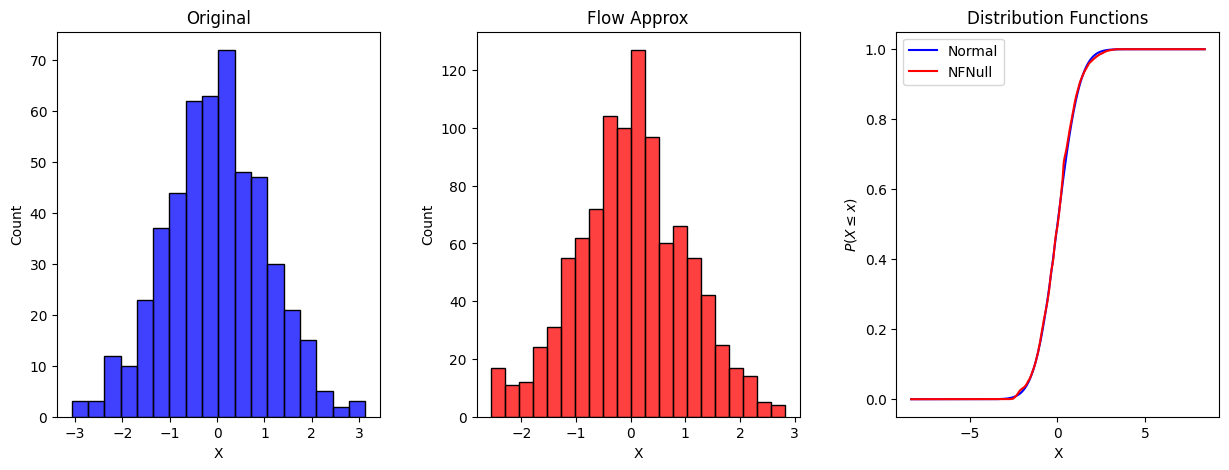

In [4]:
nfcdf = nfn.get_cdf()
x_cdf = scipy.stats.norm.cdf(nfn.grid)
plt.subplots_adjust(wspace=0.3)
plot_df = pd.DataFrame({'X': nfn.grid, 
                        'Normal CDF': x_cdf,
                        'NFNull CDF': nfcdf,
                        'Diff': np.log10(np.array([symm_diff(x, y) for x,y in zip(x_cdf, nfcdf)]))
                       })

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.3)
x_hat = nfn.sample(n=1000)

sns.histplot(x=x, ax=ax[0], color='b').set(title='Original')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Count')
sns.histplot(x=x_hat, ax=ax[1], color='r').set(title='Flow Approx')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Count')
sns.lineplot(data=plot_df, x='X', y='Normal CDF', ax=ax[2], color='blue', label='Normal').set(title='Distribution Functions')
sns.lineplot(data=plot_df, x='X', y='NFNull CDF', ax=ax[2], color='red', label='NFNull')
ax[2].set_xlabel('X')
ax[2].set_ylabel(r'$P(X \leq x)$')
fig.show()

### Trimodal distribution

Here the target is $x \sim 0.3\cdot N(-1, 0.25) + 0.3\cdot N(0, 0.25) + 0.4\cdot N(1.5, 0.25)$.

These are a non-uniform mixture of different means, with a constant variance.

In [5]:
## generate trimodal distribution
x = np.concatenate((
    scipy.stats.norm.rvs(loc=-1, scale=0.25, size=150),
    scipy.stats.norm.rvs(loc=0, scale=0.25, size=150),
    scipy.stats.norm.rvs(loc=1.5, scale=0.25, size=200)
))
nfn = NFNull(x, prescaled=False)
nfn.fit_pdf(verbose=True, patience=5)

print(f"Analytic p-value: {gmm_xdf([4.9], [-1, 0, 1.5], [0.25]*3, [0.3, 0.3, 0.4], sf=True)[1][0]}")
print(f"Empirical mean from samples {np.mean(x > 4.9)}")
print(f"Neural approx: {nfn.p_value(4.9)}")

Epoch 0: mean loss = 5.70540714263916, best = inf
Patience counter: 0/5
Epoch 1: mean loss = 3.929337501525879, best = 5.70540714263916
Patience counter: 0/5
Epoch 2: mean loss = 3.145407199859619, best = 3.929337501525879
Patience counter: 0/5
Epoch 3: mean loss = 2.5349395275115967, best = 3.145407199859619
Patience counter: 0/5
Epoch 4: mean loss = 2.110861301422119, best = 2.5349395275115967
Patience counter: 0/5
Epoch 5: mean loss = 1.7801563739776611, best = 2.110861301422119
Patience counter: 0/5
Epoch 6: mean loss = 1.6473695039749146, best = 1.7801563739776611
Patience counter: 0/5
Epoch 7: mean loss = 1.5379071235656738, best = 1.6473695039749146
Patience counter: 0/5
Epoch 8: mean loss = 1.4443742036819458, best = 1.5379071235656738
Patience counter: 0/5
Epoch 9: mean loss = 1.4029045104980469, best = 1.4443742036819458
Patience counter: 0/5
Epoch 10: mean loss = 1.341677188873291, best = 1.4029045104980469
Patience counter: 0/5
Epoch 11: mean loss = 1.3074297904968262, best

/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_28555/411524426.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  return (1-x) / (1-y)
/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_28555/411524426.py:46: RuntimeWarning: invalid value encountered in scalar divide
  return (1-x) / (1-y)
/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_28555/480407704.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


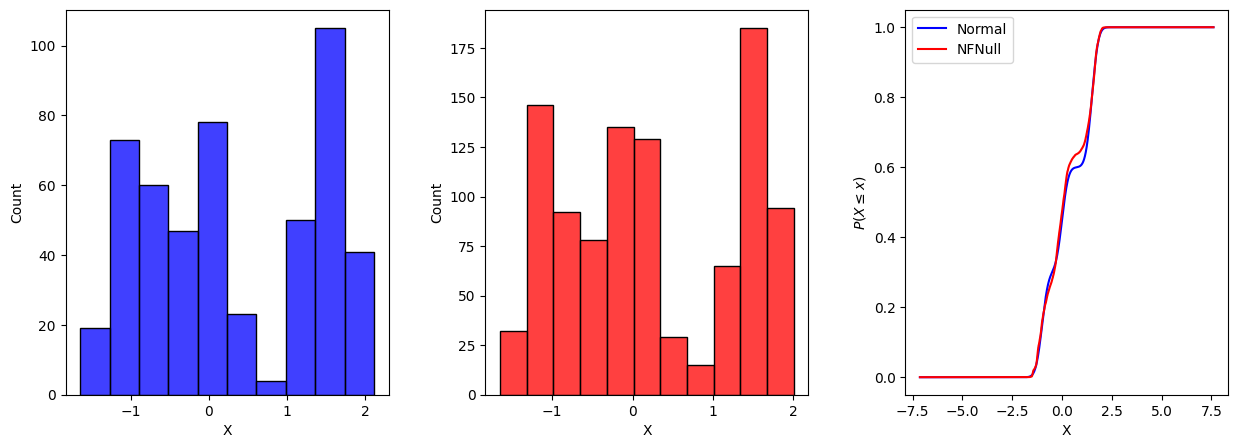

In [6]:
x_pdf, x_cdf = gmm_xdf(nfn.grid, [-1, 0, 1.5], [0.25]*3, [0.3, 0.3, 0.4])
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.3)
nfcdf = nfn.get_cdf()
plt.subplots_adjust(wspace=0.3)
plot_df = pd.DataFrame({'X': nfn.grid, 
                        'Analytic CDF': x_cdf,
                        'NFNull CDF': nfcdf,
                        'Diff': np.log10(np.abs(np.array([symm_diff(x, y) for x,y in zip(x_cdf, nfcdf)])))
                       })

x_hat = nfn.sample(n=1000)
sns.histplot(x=x, ax=ax[0], color='b')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Count')
sns.histplot(x=x_hat, ax=ax[1], color='r')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Count')
sns.lineplot(data=plot_df, x='X', y='Analytic CDF', ax=ax[2], color='blue', label='Normal')
sns.lineplot(data=plot_df, x='X', y='NFNull CDF', ax=ax[2], color='red', label='NFNull')
ax[2].set_xlabel('X')
ax[2].set_ylabel(r'$P(X \leq x)$')
fig.show()


### Exponential / Uniform Mixture

Here the target is $x \sim 0.86\cdot Exp(3) + 0.1\cdot U(0, 10) + 0.04\cdot U(9,10)$.

The 2 uniforms both add skewness and the 2nd uniform adds a small mode far from the main one.

In [7]:
x = torch.cat((
    torch.distributions.exponential.Exponential(rate=1.5).sample(torch.Size(torch.tensor([430]))), 
    torch.distributions.uniform.Uniform(low=0, high=11).sample(torch.Size(torch.tensor([50]))), 
    torch.distributions.uniform.Uniform(low=9, high=10).sample(torch.Size(torch.tensor([20]))),     
)).cpu().numpy()
nfn = NFNull(x, prescaled=False, min_support=0)
nfn.fit_pdf(verbose=True, patience=5)

cts = [430, 50, 20]
w = np.array(cts)/np.sum(cts)
q = 9.6
x_hat = nfn.sample(n=1000)
x_pdf, x_cdf = expuu_xdf(nfn.grid, w, sf=True)
nfcdf = nfn.get_cdf()

print(f"Analytic p-valu: {expuu_xdf([q], w, sf=True)[1][0]}")
print(f"Empirical mean from samples {np.mean(x > q)}")
print(f"Neural approx: {nfn.p_value(q, greater_than=True)}")

Epoch 0: mean loss = 3.341219425201416, best = inf
Patience counter: 0/5
Epoch 1: mean loss = 2.715758800506592, best = 3.341219425201416
Patience counter: 0/5
Epoch 2: mean loss = 2.4013423919677734, best = 2.715758800506592
Patience counter: 0/5
Epoch 3: mean loss = 2.026489019393921, best = 2.4013423919677734
Patience counter: 0/5
Epoch 4: mean loss = 1.7435152530670166, best = 2.026489019393921
Patience counter: 0/5
Epoch 5: mean loss = 1.4178253412246704, best = 1.7435152530670166
Patience counter: 0/5
Epoch 6: mean loss = 1.1859607696533203, best = 1.4178253412246704
Patience counter: 0/5
Epoch 7: mean loss = 1.046633243560791, best = 1.1859607696533203
Patience counter: 0/5
Epoch 8: mean loss = 0.9240726232528687, best = 1.046633243560791
Patience counter: 0/5
Epoch 9: mean loss = 0.8377877473831177, best = 0.9240726232528687
Patience counter: 0/5
Epoch 10: mean loss = 0.7732805609703064, best = 0.8377877473831177
Patience counter: 0/5
Epoch 11: mean loss = 0.7162840366363525, b

/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_28555/2946776831.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


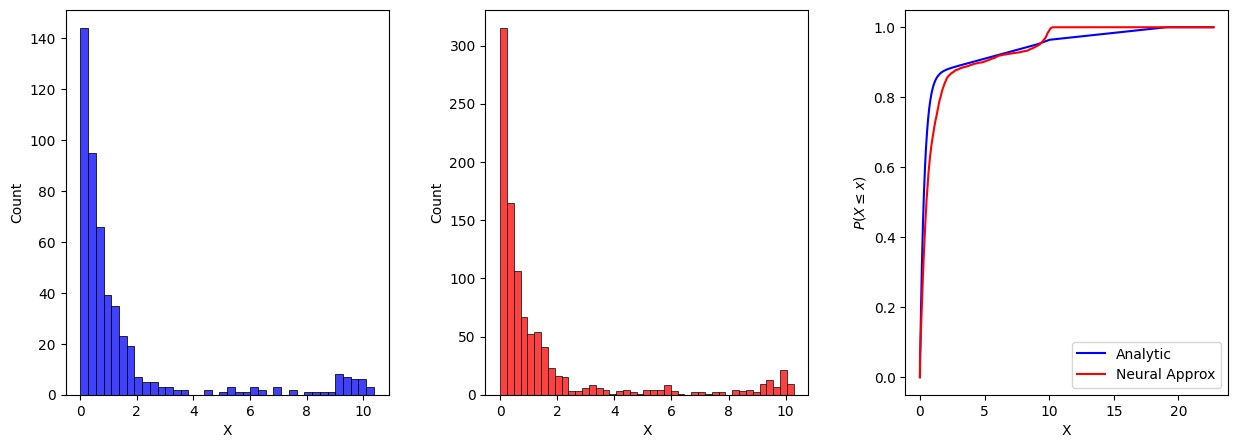

In [8]:
plot_df = pd.DataFrame({'X': nfn.grid, 
                        'Analytic CDF': 1-x_cdf,
                        'NFNull CDF': nfcdf,
                        'Diff': np.log10(np.abs(np.array([symm_diff(x, y) for x,y in zip(x_cdf, nfcdf)])))
                       })

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.3)
sns.histplot(x=x, ax=ax[0], color='b')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Count')
sns.histplot(x=x_hat, ax=ax[1], color='r')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Count')
sns.lineplot(data=plot_df, x='X', y='Analytic CDF', ax=ax[2], color='blue', label='Analytic')
sns.lineplot(data=plot_df, x='X', y='NFNull CDF', ax=ax[2], color='red', label='Neural Approx')
ax[2].set_xlabel('X')
ax[2].set_ylabel(r'$P(X \leq x)$')
fig.show()

## A Conditional Distribution

Conditional distributions can be of interest as well. Here we generate a simple bivariate distribution, where one variable (`x`-coordinate in the plot) has constant variance and the other variable (`y`-coordinate) has a variance that depends on the first variable. We learn the conditional distribution $p(Y|X)$ with NFNull by the `context` parameter, and show that the model recovers the conditional variances correctly.

For this kind of work carried further to regression modeling, see [DRIFT (Kook et al)](https://arxiv.org/abs/2405.05429)

In [79]:
def inconstant_variance(variances, n_samples=10000):
    n_bins = len(variances)
    quantiles = np.linspace(0, 1, n_bins+1)
    x = np.random.normal(0, 4, n_samples)
    bin_edges = np.quantile(x, quantiles[0:-1])
    bin_assignments = np.digitize(x, bin_edges)-1
    y = np.zeros(n_samples)
    for i in range(len(variances)):
        y[bin_assignments == i] = np.random.normal(0, variances[i], np.sum(bin_assignments == i))
    return x, y, bin_edges

x, y, b = inconstant_variance([0.5, 4.0, 2.0], n_samples=10000)
assignments = np.digitize(x, b)

<Axes: >

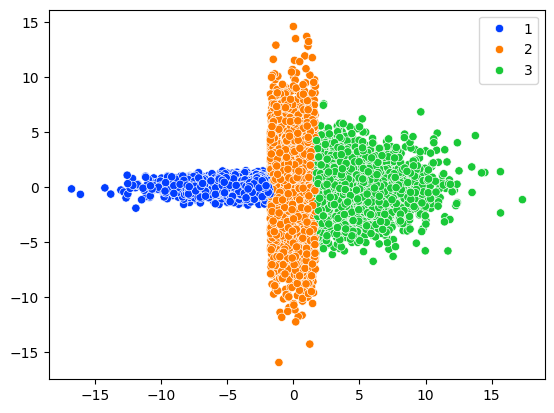

In [80]:
sns.scatterplot(x=x, y=y, hue=assignments, palette='bright')

In [81]:
model = NFNull(
    x=y,
    context=1,
    features=1,
    flow='NSF',
    prescaled=False,
)
model.fit_pdf(n_iter=1000, context=x.reshape(-1, 1), verbose=True, lr=1e-3)

Epoch 0: mean loss = 1.113588809967041, best = inf
Patience counter: 0/10
Epoch 1: mean loss = 1.0014294385910034, best = 1.113588809967041
Patience counter: 0/10
Epoch 2: mean loss = 0.9890539050102234, best = 1.0014294385910034
Patience counter: 0/10
Epoch 3: mean loss = 0.9679998755455017, best = 0.9890539050102234
Patience counter: 0/10
Epoch 4: mean loss = 0.9646933078765869, best = 0.9679998755455017
Patience counter: 0/10
Epoch 5: mean loss = 0.9653657674789429, best = 0.9646933078765869
Patience counter: 0/10
Epoch 6: mean loss = 0.9548541903495789, best = 0.9646933078765869
Patience counter: 1/10
Epoch 7: mean loss = 0.9528108835220337, best = 0.9548541903495789
Patience counter: 0/10
Epoch 8: mean loss = 0.9529704451560974, best = 0.9528108835220337
Patience counter: 0/10
Epoch 9: mean loss = 0.9504713416099548, best = 0.9528108835220337
Patience counter: 1/10
Epoch 10: mean loss = 0.9522017240524292, best = 0.9504713416099548
Patience counter: 0/10
Epoch 11: mean loss = 0.95

(-15.0, 15.0)

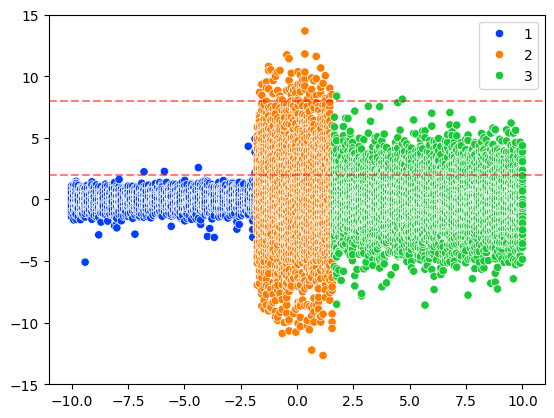

In [83]:
x2 = np.linspace(-10, 10, 200)

xy = np.zeros((200, 100))
for i, xp in enumerate(x2):
    xy[i, :] = model.sample(100, context=torch.tensor(xp, dtype=torch.float32).reshape(-1, 1).flatten())

result = np.column_stack([np.repeat(x2, 100), xy.flatten()])
assignments = np.digitize(result[:, 0], b)
sns.scatterplot(x=result[:, 0], y=result[:, 1], hue=assignments, palette='bright')
plt.axhline(y=8, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=2, color='red', linestyle='--', alpha=0.5)
plt.ylim(-15, 15)

In [84]:
for xo, yo, vo in zip([-5, 0, 5], [8]*3, [0.5, 4.0, 2.0]):
    yo = np.array(yo).reshape(-1, 1)
    xo = np.array(xo).reshape(-1, 1)
    print(f"P(Y <= {yo.flatten()[0]} | X = {xo.flatten()[0]}) = {model.p_value(yo, context=xo)}")
    print(f"--> Analytic: {scipy.stats.norm.sf(yo.flatten()[0], loc=0, scale=vo)}")

P(Y <= 8 | X = -5) = 3.999996000004e-06
--> Analytic: 6.388754400537904e-58
P(Y <= 8 | X = 0) = 0.02238697761302239
--> Analytic: 0.022750131948179198
P(Y <= 8 | X = 5) = 0.000357999642000358
--> Analytic: 3.167124183311986e-05


In [85]:
for xo, yo, vo in zip([-5, 0, 5], [2]*3, [0.5, 4.0, 2.0]):
    yo = np.array(yo).reshape(-1, 1)
    xo = np.array(xo).reshape(-1, 1)
    print(f"P(Y <= {yo.flatten()[0]} | X = {xo.flatten()[0]}) = {model.p_value(yo, context=xo)}")
    print(f"--> Analytic: {scipy.stats.norm.sf(yo.flatten()[0], loc=0, scale=vo)}")

P(Y <= 2 | X = -5) = 0.000534999465000535
--> Analytic: 3.167124183311986e-05
P(Y <= 2 | X = 0) = 0.3264786735213265
--> Analytic: 0.3085375387259869
P(Y <= 2 | X = 5) = 0.13701486298513701
--> Analytic: 0.15865525393145707


## Multivariate simulations

### MVN first

In [9]:
import numpy as np

from nfnull import NFNull
from scipy.stats import multivariate_normal

mean = [2.0, -1.0]
cov = [[2.0, 0.8], [0.8, 0.5]]
mv_normal_data = np.random.multivariate_normal(mean, cov, 1000)

model = NFNull(
    x=mv_normal_data,
    features=2,
    flow='NSF',
    passes=2,
    transforms=2,
    prescaled=False
)
model.fit_pdf(verbose=True, patience=10)

Epoch 0: mean loss = 2.5702340602874756, best = inf
Patience counter: 0/10
Epoch 1: mean loss = 2.4147989749908447, best = 2.5702340602874756
Patience counter: 0/10
Epoch 2: mean loss = 2.3987250328063965, best = 2.4147989749908447
Patience counter: 0/10
Epoch 3: mean loss = 2.403744697570801, best = 2.3987250328063965
Patience counter: 0/10
Epoch 4: mean loss = 2.414639949798584, best = 2.3987250328063965
Patience counter: 1/10
Epoch 5: mean loss = 2.3487653732299805, best = 2.3987250328063965
Patience counter: 2/10
Epoch 6: mean loss = 2.345790147781372, best = 2.3487653732299805
Patience counter: 0/10
Epoch 7: mean loss = 2.343710422515869, best = 2.345790147781372
Patience counter: 0/10
Epoch 8: mean loss = 2.372284412384033, best = 2.343710422515869
Patience counter: 0/10
Epoch 9: mean loss = 2.382183074951172, best = 2.343710422515869
Patience counter: 1/10
Epoch 10: mean loss = 2.356031656265259, best = 2.343710422515869
Patience counter: 2/10
Epoch 11: mean loss = 2.32483291625

In [10]:
points = [
    [2.0, -1.0],
    [8.0, -3.0],
    [1.0, -1.0]
]

for point in points:
    print(f"P(X1 <= {point[0]} & X2 <= {point[1]})")
    print(f"-->     Flow: {model.p_value(point, n=10000, greater_than=False):.5f}")
    print(f"--> Analytic: {multivariate_normal.cdf(point, mean=[2.0, -1.0], cov=[[2.0, 0.8], [0.8, 0.5]]):.5f}")

P(X1 <= 2.0 & X2 <= -1.0)
-->     Flow: 0.28057
--> Analytic: 0.39758
P(X1 <= 8.0 & X2 <= -3.0)
-->     Flow: 0.00690
--> Analytic: 0.00234
P(X1 <= 1.0 & X2 <= -1.0)
-->     Flow: 0.13119
--> Analytic: 0.22358


In [11]:
samples = model.sample(10000)
print("Sample mean:", np.mean(samples, axis=0))
print("True mean:", mean)
print("Sample cov:", np.cov(samples.T))
print("True cov:", cov)

Sample mean: [ 2.46349227 -0.99521609]
True mean: [2.0, -1.0]
Sample cov: [[1.66551569 0.71509056]
 [0.71509056 0.55337366]]
True cov: [[2.0, 0.8], [0.8, 0.5]]


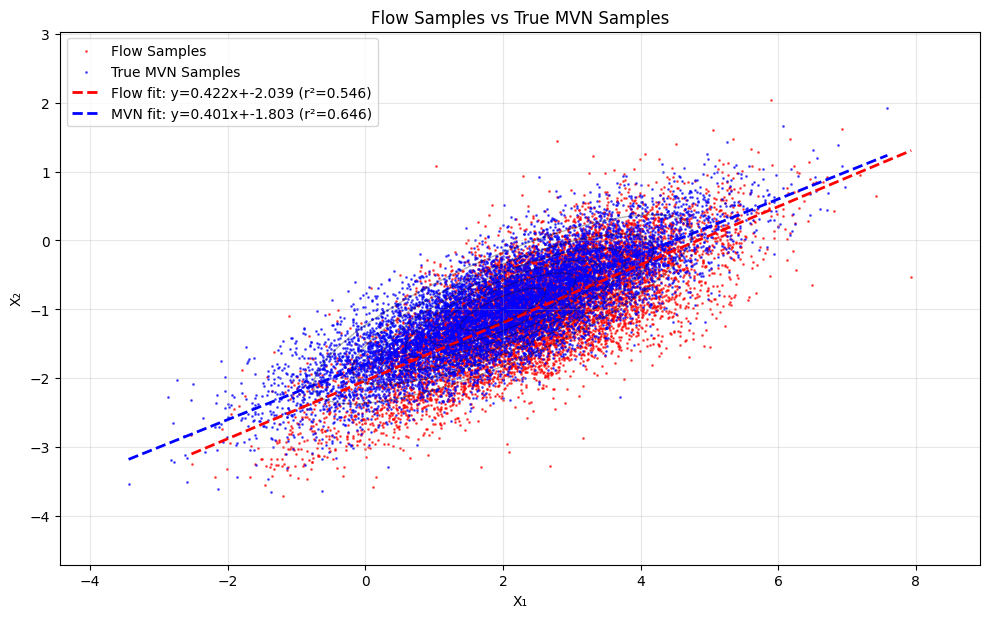

In [12]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy import stats

flow_samples = model.sample(10000)
mvn_samples = multivariate_normal.rvs(mean=mean, cov=cov, size=10000)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(flow_samples[:, 0], flow_samples[:, 1], 
          alpha=0.6, s=1, color='red', label='Flow Samples')
ax.scatter(mvn_samples[:, 0], mvn_samples[:, 1], 
          alpha=0.6, s=1, color='blue', label='True MVN Samples')

flow_slope, flow_intercept, flow_r, flow_p, flow_se = stats.linregress(flow_samples[:, 0], flow_samples[:, 1])
flow_line_x = np.array([flow_samples[:, 0].min(), flow_samples[:, 0].max()])
flow_line_y = flow_slope * flow_line_x + flow_intercept
ax.plot(flow_line_x, flow_line_y, 'red', linewidth=2, linestyle='--', 
        label=f'Flow fit: y={flow_slope:.3f}x+{flow_intercept:.3f} (r²={flow_r**2:.3f})')

mvn_slope, mvn_intercept, mvn_r, mvn_p, mvn_se = stats.linregress(mvn_samples[:, 0], mvn_samples[:, 1])
mvn_line_x = np.array([mvn_samples[:, 0].min(), mvn_samples[:, 0].max()])
mvn_line_y = mvn_slope * mvn_line_x + mvn_intercept
ax.plot(mvn_line_x, mvn_line_y, 'blue', linewidth=2, linestyle='--',
        label=f'MVN fit: y={mvn_slope:.3f}x+{mvn_intercept:.3f} (r²={mvn_r**2:.3f})')


x_range = np.linspace(min(np.min(flow_samples[:, 0]), np.min(mvn_samples[:, 0])) - 1,
                      max(np.max(flow_samples[:, 0]), np.max(mvn_samples[:, 0])) + 1, 100)
y_range = np.linspace(min(np.min(flow_samples[:, 1]), np.min(mvn_samples[:, 1])) - 1,
                      max(np.max(flow_samples[:, 1]), np.max(mvn_samples[:, 1])) + 1, 100)
X, Y = np.meshgrid(x_range, y_range)
pos = np.dstack((X, Y))
rv = multivariate_normal(mean, cov)
ax.contour(X, Y, rv.pdf(pos), colors='black', alpha=0.3, linewidths=1)

ax.set_xlabel('X₁')
ax.set_ylabel('X₂')
ax.set_title('Flow Samples vs True MVN Samples')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

### Swiss roll

Swiss roll shape: (1000, 3)
Swiss roll range X: -9.698333849135365 to 12.760586342838183
Swiss roll range Y: -0.03847697094980779 to 20.99759518961371
Swiss roll range Z: -11.203599063500754 to 14.229501310378458


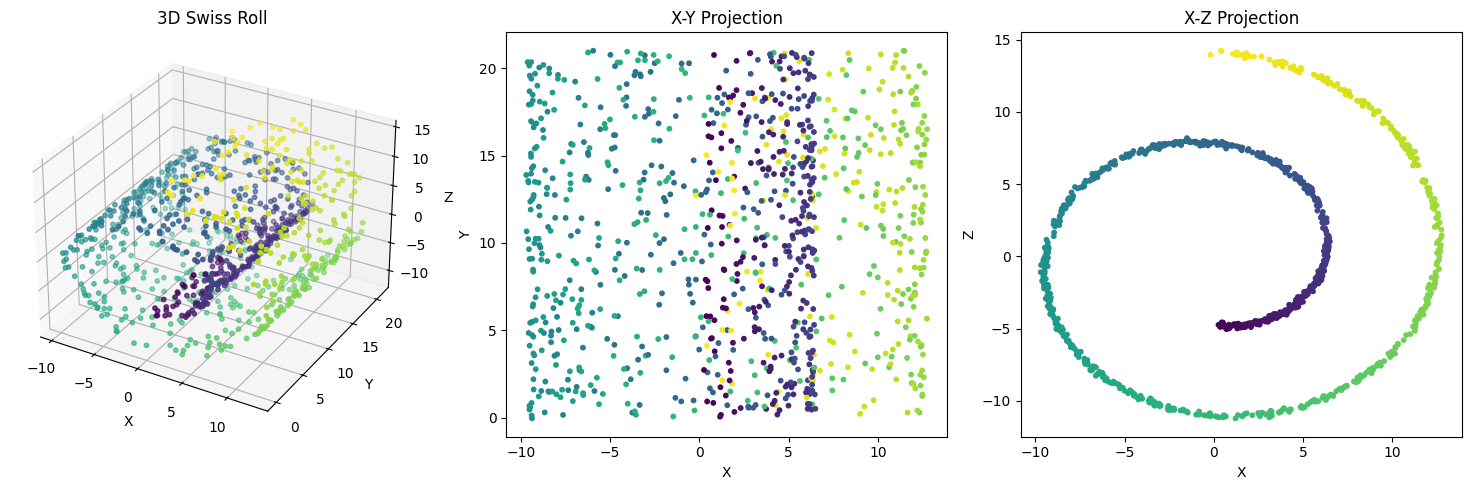

In [13]:
# 3D Swiss Roll Generation
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import make_swiss_roll
from nfnull import NFNull

# Generate 3D Swiss Roll data
n_samples = 1000
swiss_roll_data, swiss_roll_color = make_swiss_roll(n_samples=n_samples, noise=0.1, random_state=42)

print("Swiss roll shape:", swiss_roll_data.shape)
print("Swiss roll range X:", swiss_roll_data[:, 0].min(), "to", swiss_roll_data[:, 0].max())
print("Swiss roll range Y:", swiss_roll_data[:, 1].min(), "to", swiss_roll_data[:, 1].max()) 
print("Swiss roll range Z:", swiss_roll_data[:, 2].min(), "to", swiss_roll_data[:, 2].max())

# Visualize the 3D Swiss roll
fig = plt.figure(figsize=(15, 5))

# 3D plot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(swiss_roll_data[:, 0], swiss_roll_data[:, 1], swiss_roll_data[:, 2], 
            c=swiss_roll_color, cmap='viridis', s=10)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Swiss Roll')

# 2D projections
ax2 = fig.add_subplot(132)
ax2.scatter(swiss_roll_data[:, 0], swiss_roll_data[:, 1], c=swiss_roll_color, cmap='viridis', s=10)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('X-Y Projection')

ax3 = fig.add_subplot(133)
ax3.scatter(swiss_roll_data[:, 0], swiss_roll_data[:, 2], c=swiss_roll_color, cmap='viridis', s=10)
ax3.set_xlabel('X')
ax3.set_ylabel('Z')
ax3.set_title('X-Z Projection')

plt.tight_layout()
plt.show()

In [14]:
# Train NFNull model on 3D Swiss Roll (following your MVN analysis structure)
swiss_model_3d = NFNull(
    x=swiss_roll_data,
    features=3,  
    flow='NSF',  
    passes=2,
    transforms=8,  
    prescaled=False,
    bins=32,
    hidden_features=(128, 128, 128, 128, 128)
)

swiss_model_3d.fit_pdf(verbose=True, patience=20, n_iter=3000)  # might need more iterations for 3D

Epoch 0: mean loss = 5.653869152069092, best = inf
Patience counter: 0/20
Epoch 1: mean loss = 3.90925669670105, best = 5.653869152069092
Patience counter: 0/20
Epoch 2: mean loss = 3.824303150177002, best = 3.90925669670105
Patience counter: 0/20
Epoch 3: mean loss = 3.7979257106781006, best = 3.824303150177002
Patience counter: 0/20
Epoch 4: mean loss = 3.519867420196533, best = 3.7979257106781006
Patience counter: 0/20
Epoch 5: mean loss = 3.4983162879943848, best = 3.519867420196533
Patience counter: 0/20
Epoch 6: mean loss = 3.460667133331299, best = 3.4983162879943848
Patience counter: 0/20
Epoch 7: mean loss = 3.2196130752563477, best = 3.460667133331299
Patience counter: 0/20
Epoch 8: mean loss = 3.3212361335754395, best = 3.2196130752563477
Patience counter: 0/20
Epoch 9: mean loss = 3.3873891830444336, best = 3.2196130752563477
Patience counter: 1/20
Epoch 10: mean loss = 3.3535146713256836, best = 3.2196130752563477
Patience counter: 2/20
Epoch 11: mean loss = 3.020097732543

In [15]:
def empirical_cdf_3d(data, point):
    """Compute empirical 3D CDF P(X1 <= x1 AND X2 <= x2 AND X3 <= x3)"""
    return np.mean((data[:, 0] <= point[0]) & 
                   (data[:, 1] <= point[1]) & 
                   (data[:, 2] <= point[2]))

test_points = [
    [0.0, 0.0, 0.0],     # Center region
    [5.0, 5.0, 5.0],     # One corner
    [-8.0, 0.0, -8.0],   # Edge region
    [2.0, 3.0, -3.0],    # Mixed region
    [0.0, 10.0, 0.0],    # High Y region (linear dimension)
]

print("P-value comparisons (P(X1 <= x1 & X2 <= x2 & X3 <= x3)):")
print("=" * 60)
for point in test_points:
    flow_p = swiss_model_3d.p_value(point, n=100000, greater_than=False)
    empirical_p = empirical_cdf_3d(swiss_roll_data, point)
    ratio = flow_p / empirical_p if empirical_p > 0 else float('inf')
    print(f"Point {point}:")
    print(f"-->     Flow: {flow_p:.6f}")
    print(f"--> Empirical: {empirical_p:.6f}")
    print()

P-value comparisons (P(X1 <= x1 & X2 <= x2 & X3 <= x3)):
Point [0.0, 0.0, 0.0]:
-->     Flow: 0.000700
--> Empirical: 0.000000

Point [5.0, 5.0, 5.0]:
-->     Flow: 0.095329
--> Empirical: 0.106000

Point [-8.0, 0.0, -8.0]:
-->     Flow: 0.000010
--> Empirical: 0.000000

Point [2.0, 3.0, -3.0]:
-->     Flow: 0.028990
--> Empirical: 0.037000

Point [0.0, 10.0, 0.0]:
-->     Flow: 0.092529
--> Empirical: 0.091000



In [16]:
swiss_samples_3d = swiss_model_3d.sample(10000)

print("3D Swiss Roll Sample Statistics:")
print("=" * 40)
print("Original mean:", np.mean(swiss_roll_data, axis=0))
print("Flow mean:    ", np.mean(swiss_samples_3d, axis=0))
print("\nOriginal cov:")
print(np.cov(swiss_roll_data.T))
print("\nFlow cov:")
print(np.cov(swiss_samples_3d.T))

orig_corr = np.corrcoef(swiss_roll_data.T)
flow_corr = np.corrcoef(swiss_samples_3d.T)
print("\nOriginal correlations:")
print(orig_corr)
print("\nFlow correlations:")
print(flow_corr)

3D Swiss Roll Sample Statistics:
Original mean: [ 2.00351339 10.64759924  0.16018708]
Flow mean:     [ 1.67037825 11.12299613 -0.52412006]

Original cov:
[[43.14330482  1.61577038  6.22317039]
 [ 1.61577038 37.72396321  1.72826845]
 [ 6.22317039  1.72826845 47.68923016]]

Flow cov:
[[45.02085442 -0.23731678  4.41646509]
 [-0.23731678 37.41241993  0.44252504]
 [ 4.41646509  0.44252504 47.97239656]]

Original correlations:
[[1.         0.04005108 0.13719707]
 [0.04005108 1.         0.0407467 ]
 [0.13719707 0.0407467  1.        ]]

Flow correlations:
[[ 1.         -0.00578247  0.09503252]
 [-0.00578247  1.          0.01044562]
 [ 0.09503252  0.01044562  1.        ]]


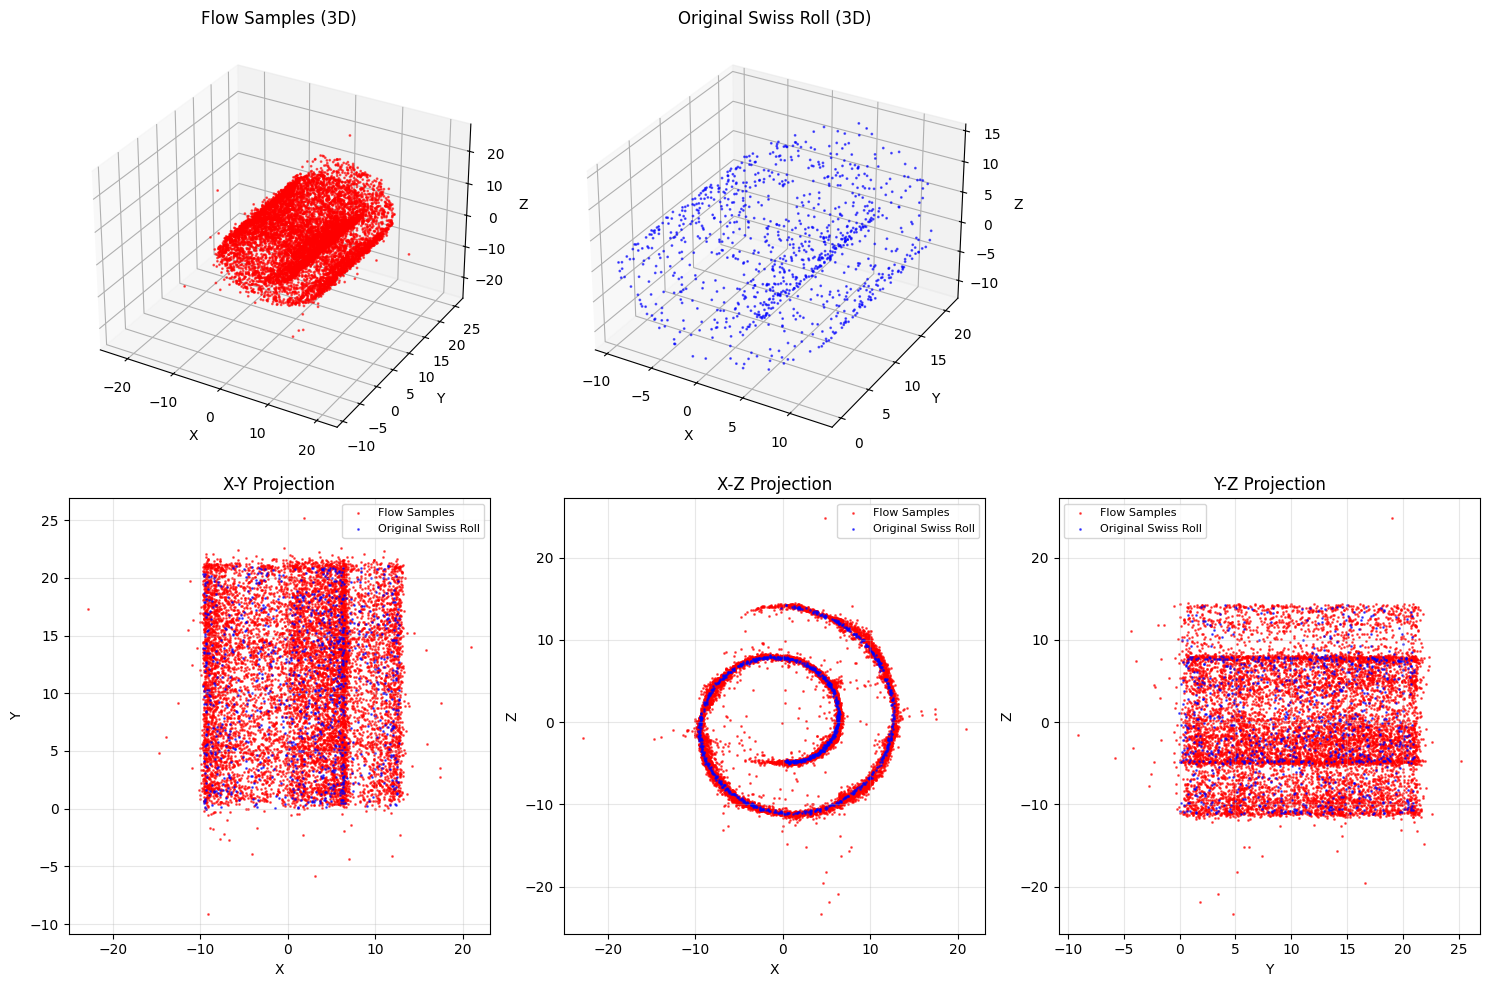

In [17]:
fig = plt.figure(figsize=(15, 10))

# 3D scatter plots
ax1 = fig.add_subplot(231, projection='3d')
ax1.scatter(swiss_samples_3d[:, 0], swiss_samples_3d[:, 1], swiss_samples_3d[:, 2], 
           alpha=0.6, s=1, color='red', label='Flow Samples')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Flow Samples (3D)')

ax2 = fig.add_subplot(232, projection='3d')
ax2.scatter(swiss_roll_data[:, 0], swiss_roll_data[:, 1], swiss_roll_data[:, 2], 
           alpha=0.6, s=1, color='blue', label='Original Swiss Roll')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Original Swiss Roll (3D)')

projections = [
    (0, 1, 'X', 'Y'),  # X-Y
    (0, 2, 'X', 'Z'),  # X-Z  
    (1, 2, 'Y', 'Z')   # Y-Z
]

for i, (dim1, dim2, label1, label2) in enumerate(projections):
    ax = fig.add_subplot(2, 3, i+4)
    
    ax.scatter(swiss_samples_3d[:, dim1], swiss_samples_3d[:, dim2], 
              alpha=0.6, s=1, color='red', label='Flow Samples')
    ax.scatter(swiss_roll_data[:, dim1], swiss_roll_data[:, dim2], 
              alpha=0.6, s=1, color='blue', label='Original Swiss Roll')

    
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    ax.set_title(f'{label1}-{label2} Projection')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### <span style="color:red"> TODO </span>

Need to demonstrate NFs with $t$-distribution as base distribution (`flow=TNSF`).